# Test localization and co-localization of two diseases, using network propagation

Test on simulated networks, where we can control how localized and co-localized node sets are

### Author: Brin Rosenthal (sbrosenthal@ucsd.edu)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import networkx as nx
import pandas as pd
import random
import scipy

import mygene
mg = mygene.MyGeneInfo()

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

import sys
sys.path.append('../source')
import plotting_results
import network_prop

import imp
imp.reload(plotting_results)
imp.reload(network_prop)


% matplotlib inline

## First, let's create a random graph

- We will start with the connected Watts Strogatz random graph, created using the NetworkX package.  This graph generator will allow us to create random graphs which are guaranteed to be fully connected, and gives us control over how connected the graph is, and how structured it is.  Documentation for the function can be found here https://networkx.github.io/documentation/latest/reference/generated/networkx.generators.random_graphs.connected_watts_strogatz_graph.html#networkx.generators.random_graphs.connected_watts_strogatz_graph

<img src="screenshots/connected_watts_strogatz_graph_nx_docs.png" width="600" height="600">


## Control localization

- We can control the localization of nodes by seeding the network propagation with a focal node and that focal node's neighbors.  This will guarantee that the seed nodes will be very localized in the graph
- As a first example, let's create a random network, with two localized sets.
- The network contains 100 nodes, with each node first connected to its 5 nearest neighbors.  
- Once these first edges are connected, each edge is randomly rewired with probability p = 0.12 (so approximately 12 percent of the edges in the graph will be rewired)
- With this rewiring probability of 0.12, most of the structure in the graph is maintained, but some randomness has been introduced

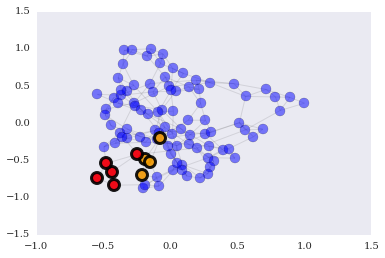

In [25]:
# Create a random connected-Watts-Strogatz graph
Gsim = nx.connected_watts_strogatz_graph(100,5,.12)

seed1 = [0]
seed1.extend(nx.neighbors(Gsim,seed1[0]))
seed2 = [10]
seed2.extend(nx.neighbors(Gsim,seed2[0]))
#seed = list(np.random.choice(Gsim.nodes(),size=6,replace=False))

pos = nx.spring_layout(Gsim)

nx.draw_networkx_nodes(Gsim,pos=pos,node_size=100,alpha=.5,node_color = 'blue')
nx.draw_networkx_nodes(Gsim,pos=pos,nodelist=seed1,node_size=120,alpha=.9,node_color='orange',linewidths=3)
nx.draw_networkx_nodes(Gsim,pos=pos,nodelist=seed2,node_size=120,alpha=.9,node_color='red',linewidths=3)
nx.draw_networkx_edges(Gsim,pos=pos,alpha=.1)
plt.grid('off')

#plt.savefig('/Users/brin/Google Drive/UCSD/update_16_03/non_colocalization_illustration.png',dpi=300,bbox_inches='tight')


- In the network shown above, we plot our random connected Watts-Strogatz graph, highlighting two localized seed node sets, shown in red and orange, with bold outlines.
- These seed node sets were created by selecting two focal node, and those focal node's neighbors, thus resulting in two node sets which appear highly localized to the eye.  


- Since the graph is composed of nearest neighbor relations (with some randomness added on), and it was initiated with node ids ranging from 0 to 99 (these are the default node names- they can be changed using nx.relabel_nodes()), we can control the co-localization of these node sets by selecting seed nodes which are close together, for high co-localization (e.g. 0 and 5), or which are far apart, for low co-localization (e.g. 0 and 50).  


- Below, we will display node sets with both high and low co-localization
- Our ability to control the co-localization in this way will become worse as the rewiring probability increases, and the structure in the graph is destroyed.


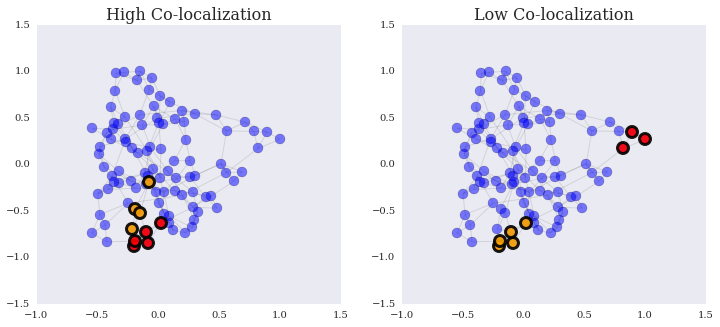

In [30]:

# highly co-localized gene sets
seed1 = [0]
seed1.extend(nx.neighbors(Gsim,seed1[0]))
seed2 = [5]
seed2.extend(nx.neighbors(Gsim,seed2[0]))
#seed = list(np.random.choice(Gsim.nodes(),size=6,replace=False))


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
nx.draw_networkx_nodes(Gsim,pos=pos,node_size=100,alpha=.5,node_color = 'blue')
nx.draw_networkx_nodes(Gsim,pos=pos,nodelist=seed1,node_size=120,alpha=.9,node_color='orange',linewidths=3)
nx.draw_networkx_nodes(Gsim,pos=pos,nodelist=seed2,node_size=120,alpha=.9,node_color='red',linewidths=3)
nx.draw_networkx_edges(Gsim,pos=pos,alpha=.1)
plt.title('High Co-localization',fontsize=16)
plt.grid('off')

# low co-localized gene sets
seed1 = [5]
seed1.extend(nx.neighbors(Gsim,seed1[0]))
seed2 = [30]
seed2.extend(nx.neighbors(Gsim,seed2[0]))
#seed = list(np.random.choice(Gsim.nodes(),size=6,replace=False))

plt.subplot(1,2,2)
nx.draw_networkx_nodes(Gsim,pos=pos,node_size=100,alpha=.5,node_color = 'blue')
nx.draw_networkx_nodes(Gsim,pos=pos,nodelist=seed1,node_size=120,alpha=.9,node_color='orange',linewidths=3)
nx.draw_networkx_nodes(Gsim,pos=pos,nodelist=seed2,node_size=120,alpha=.9,node_color='red',linewidths=3)
nx.draw_networkx_edges(Gsim,pos=pos,alpha=.1)
plt.title('Low Co-localization',fontsize=16)
plt.grid('off')


# Can we quantify this concept of localization?

- Sometimes it's not easy to tell by eye if a node set is localized.  
- We can use network propagation simulations to quantify this concept of localization

- Network propagation is a tool which initiates a seed node set with high 'heat', and then over the course of a number of iterations spreads this heat around to nearby nodes. 
- At the end of the simulation, nodes with the highest heat are those which are most closely related to the seed nodes.

- We implemented the network propagation method described in Vanunu et. al. 2010 (Vanunu, Oron, et al. "Associating genes and protein complexes with disease via network propagation." PLoS Comput Biol 6.1 (2010): e1000641.)

<img src="screenshots/vanunu_abstracg.png">

### Localization using network propagation
- We can use network propagation to evaluate how localized a seed node set is in the network.
- If the seed node set is highly localized, the 'heat' from the network propagation simulation will be bounced around between seed nodes, and less of it will dissipate to distant parts of the network.
- We will evaluate the distribution of the heat from all the nodes, using the kurtosis (the fourth standardized moment), which measures how 'tailed' the distribution is.  If our distribution has high kurtosis, this indicates that much of the 'heat' has stayed localized near the seed set.  If our distribution has a low kurtosis, this indicates that the 'heat' has not stayed localized, but has diffused to distant parts of the network.  

<img src="screenshots/kurtosis.png">

### Random baseline for comparison
- To evaluate localization in this way, we need a baseline to compare to.
- Te establish the baseline we take our original network, and shuffle the edges, while preserving degree (so nodes which originally had 5 neighbors will still have 5 neighbors, although these neighbors will now be spread randomly throughout the graph)

- For example, below we show the heat propagation on a non-shuffled graph, from a localized seed set (left), and the heat propagation from the same seed set, on an edge-shuffled graph (right).  The nodes on the left and right have the same _number_ of neighbors, but they have different identities.  
- The total amount of heat in the graph is conserved in both cases, but the heat distributions look very different- the seed nodes retain much less of their original heat in the edge-shuffled case.

<img src="screenshots/L_edge_shuffled.png">

- We will calculate the kurtosis of the heat distribution over a large number of different edge-shuffled networks (below- 1000 repetitions), to build up the baseline distribution of kurtosis values.

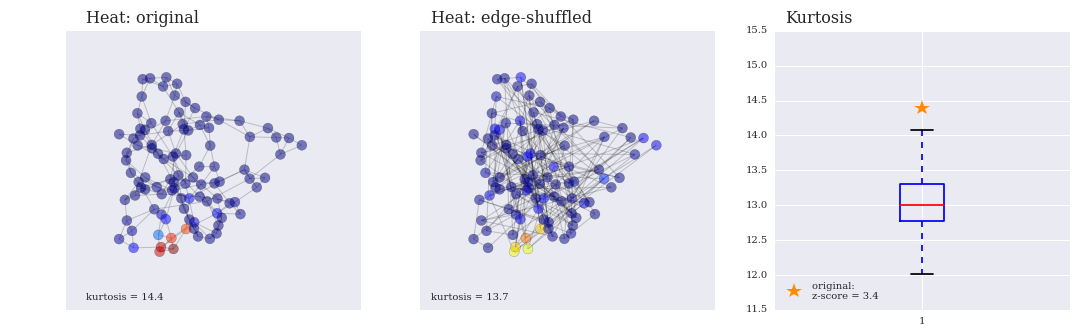

In [34]:
Wprime_ring = network_prop.normalized_adj_matrix(Gsim)
Fnew_ring = network_prop.network_propagation(Gsim,Wprime_ring,seed1)
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
nx.draw_networkx_nodes(Gsim,pos=pos,node_size=100,alpha=.5,node_color=Fnew_ring[Gsim.nodes()],cmap='jet',
                      vmin=0,vmax=max(Fnew_ring))
nx.draw_networkx_edges(Gsim,pos=pos,alpha=.2)
var_ring = plotting_results.nsf(np.var(Fnew_ring),3)
kurt_ring = plotting_results.nsf(scipy.stats.kurtosis(Fnew_ring),3)
plt.annotate('kurtosis = ' + str(kurt_ring),
             xy=(.08,.1),xycoords='figure fraction')
plt.annotate('Heat: original',xy=(.08,.93),xycoords='figure fraction',fontsize=16)
plt.xticks([],[])
plt.yticks([],[])
plt.grid('off')

num_reps = 1000
var_rand_list,kurt_rand_list = [],[]
for r in range(num_reps):
    G_temp = nx.configuration_model(Gsim.degree().values())
    G_rand = nx.Graph()  # switch from multigraph to digraph
    G_rand.add_edges_from(G_temp.edges())
    G_rand = nx.relabel_nodes(G_rand,dict(zip(range(len(G_rand.nodes())),Gsim.degree().keys())))
    Wprime_rand = network_prop.normalized_adj_matrix(G_rand)

    Fnew_rand = network_prop.network_propagation(G_rand,Wprime_rand,seed1)
    
    var_rand_list.append(np.var(Fnew_rand))
    kurt_rand_list.append(scipy.stats.kurtosis(Fnew_rand))
    
    
plt.subplot(1,3,2)
nx.draw_networkx_nodes(G_rand,pos=pos,node_size=100,alpha=.5,node_color=Fnew_rand[G_rand.nodes()],cmap='jet',
                      vmin=0,vmax=max(Fnew_ring))
nx.draw_networkx_edges(G_rand,pos=pos,alpha=.2)
var_rand = plotting_results.nsf(np.var(Fnew_rand),3)
kurt_rand = plotting_results.nsf(scipy.stats.kurtosis(Fnew_rand),3)
plt.annotate('kurtosis = ' + str(kurt_rand),
             xy=(.40,.1),xycoords='figure fraction')
plt.annotate('Heat: edge-shuffled',xy=(.40,.93),xycoords='figure fraction',fontsize=16)
plt.xticks([],[])
plt.yticks([],[])
plt.grid('off')

plt.subplot(1,3,3)
plt.boxplot(kurt_rand_list)
z_score = (kurt_ring-np.mean(kurt_rand_list))/np.std(kurt_rand_list)
z_score = plotting_results.nsf(z_score,n=2)
plt.plot(1,kurt_ring,'*',color='darkorange',markersize=16,label='original: \nz-score = '+ str(z_score))
plt.annotate('Kurtosis',xy=(.73,.93),xycoords='figure fraction',fontsize=16)
plt.legend(loc='lower left')



#plt.savefig('/Users/brin/Google Drive/UCSD/update_16_03/localization_NWS_p1_variance.png',dpi=300,bbox_inches='tight')




- Above (right panel) we see that when a node set is highly localized, it has a higher kurtosis value than would be expected from a non-localized gene set (the orange star represents the kurtosis of the heat distribution on the original graph, and the boxplot represents the distribution of 1000 kurtosis values on edge-shuffled networks).  The orange star is significantly higher than the baseline distribution.

# Co-localization using network propagation

- We now build on our understanding of localization using network propagation to establish a measurement of how _co-localized_ two node sets are in a network.  

- In the first example we discussed (above), we came up with a general understanding of co-localization, where two node sets were co-localized if they were individually localized, _and_ were nearby in network space.  
- In order to measure this co-localization using network propagation, we will first seed 2 simulations with each node set, then we will take the dot-product (or the sum of the pairwise product) of the resulting heat vectors.
- When node sets are co-localized, there will be more nodes which are hot in both heat vectors (again we compare to a distribution of heat dot-products on degree preserving edge-shuffled graphs)


0.00476005745598


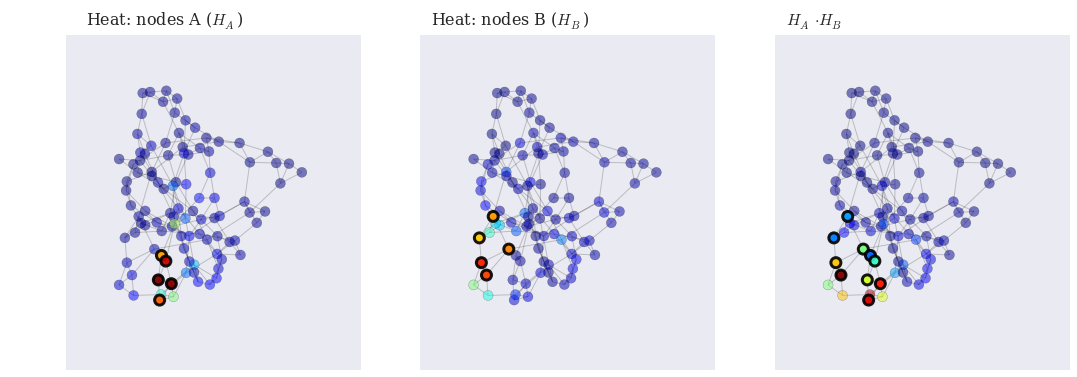

In [45]:
seed1 = Gsim.nodes()[0:5]  #nx.neighbors(Gsim,Gsim.nodes()[0])
seed2 = Gsim.nodes()[10:15]  #nx.neighbors(Gsim,Gsim.nodes()[5])  #Gsim.nodes()[27:32]
seed3 = Gsim.nodes()[20:25]

Fnew1 = network_prop.network_propagation(Gsim,Wprime_ring,seed1,alpha=.9,num_its=20)
Fnew2 = network_prop.network_propagation(Gsim,Wprime_ring,seed2,alpha=.9,num_its=20)
F12 = Fnew1*Fnew2
F12.sort(ascending=False)
#Fnew1.sort(ascending=False)
#Fnew2.sort(ascending=False)
Fnew1_norm = Fnew1/np.linalg.norm(Fnew1)
Fnew2_norm = Fnew2/np.linalg.norm(Fnew2)


dot_12 = np.sum(F12.head(10))
print(dot_12)

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
nx.draw_networkx_nodes(Gsim,pos=pos,node_size=100,alpha=.5,node_color=Fnew1[Gsim.nodes()],
                       cmap='jet', vmin=0,vmax=max(Fnew1))
nx.draw_networkx_nodes(Gsim,pos=pos,nodelist=seed1,
                       node_size=100,alpha=.9,node_color=Fnew1[seed1],
                       cmap='jet', vmin=0,vmax=max(Fnew1),linewidths=3)
nx.draw_networkx_edges(Gsim,pos=pos,alpha=.2)
plt.grid('off')
plt.xticks([],[])
plt.yticks([],[])
plt.annotate('Heat: nodes A ($H_A$)',xy=(.08,.93),xycoords='figure fraction',fontsize=16)

plt.subplot(1,3,2)
nx.draw_networkx_nodes(Gsim,pos=pos,node_size=100,alpha=.5,node_color=Fnew2[Gsim.nodes()],
                       cmap='jet', vmin=0,vmax=max(Fnew1))
nx.draw_networkx_nodes(Gsim,pos=pos,nodelist=seed2,
                       node_size=100,alpha=.9,node_color=Fnew2[seed2],
                       cmap='jet', vmin=0,vmax=max(Fnew1),linewidths=3)
nx.draw_networkx_edges(Gsim,pos=pos,alpha=.2)
plt.grid('off')
plt.xticks([],[])
plt.yticks([],[])
plt.annotate('Heat: nodes B ($H_B$)',xy=(.4,.93),xycoords='figure fraction',fontsize=16)

plt.subplot(1,3,3)
nx.draw_networkx_nodes(Gsim,pos=pos,node_size=100,alpha=.5,node_color=Fnew1[Gsim.nodes()]*Fnew2[Gsim.nodes()],
                       cmap='jet', vmin=0,vmax=max(Fnew1*Fnew2))
nx.draw_networkx_nodes(Gsim,pos=pos,nodelist=seed2,
                       node_size=100,alpha=.9,node_color=Fnew1[seed2]*Fnew2[seed2],
                       cmap='jet', vmin=0,vmax=max(Fnew1*Fnew2),linewidths=3)
nx.draw_networkx_nodes(Gsim,pos=pos,nodelist=seed1,
                       node_size=100,alpha=.9,node_color=Fnew1[seed1]*Fnew2[seed1],
                       cmap='jet', vmin=0,vmax=max(Fnew1*Fnew2),linewidths=3)
nx.draw_networkx_edges(Gsim,pos=pos,alpha=.2)
plt.grid('off')
plt.xticks([],[])
plt.yticks([],[])
plt.annotate('$H_A \cdot H_B$',xy=(.73,.93),xycoords='figure fraction',fontsize=16)



- In the figure above, we show an example of this co-localization concept.  
- In the left panel we show the heat vector of the simulation seeded by node set A (warmer colors indicate hotter nodes, and bold outlines indicate seed nodes)
- In the middle panel we show the heat vector of the simulation seeded by node set B
- The right panel shows the pairwise product of the heat vectors (note color scale is different for this panel).  The nodes between the two seed sets are the hottest, meaning that these are the nodes most likely related to both seed gene sets.

- If these node sets are truly co-localized, then the sum of the heat product (the dot product) will be higher than random.  This is what we will test below.

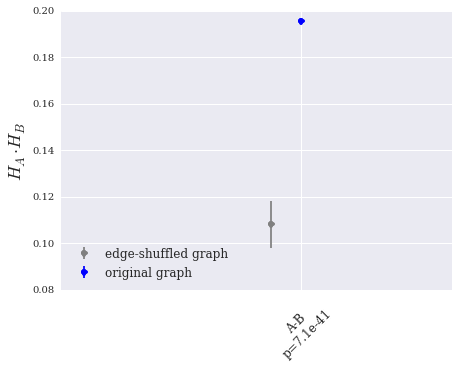

In [44]:
results_dict = network_prop.calc_3way_colocalization(Gsim,seed1,seed2,seed3,num_reps=100,num_genes=5,
                                                     replace=False,savefile=False,alpha=.5,print_flag=False,)

import scipy

num_reps = results_dict['num_reps']

dot_sfari_epi=results_dict['sfari_epi']
dot_sfari_epi_rand=results_dict['sfari_epi_rand']
#U,p = scipy.stats.mannwhitneyu(dot_sfari_epi,dot_sfari_epi_rand)
t,p = scipy.stats.ttest_ind(dot_sfari_epi,dot_sfari_epi_rand)
psig_SE = plotting_results.nsf(p,n=2)

plt.figure(figsize=(7,5))
plt.errorbar(-.1,np.mean(dot_sfari_epi_rand),2*np.std(dot_sfari_epi_rand)/np.sqrt(num_reps),fmt='o',
             ecolor='gray',markerfacecolor='gray',label='edge-shuffled graph')
plt.errorbar(0,np.mean(dot_sfari_epi),2*np.std(dot_sfari_epi)/np.sqrt(num_reps),fmt='bo',
            label='original graph')
plt.xlim(-.8,.5)
plt.legend(loc='lower left',fontsize=12)
plt.xticks([0],['A-B \np='+str(psig_SE)],rotation=45,fontsize=12)
plt.ylabel('$H_{A} \cdot H_{B}$',fontsize=18)


- In the figure above, we show the heat dot product of node set A and node set B, on the original graph (blue dot), and on 100 edge-shuffled graphs (gray dot with error bars).
- Using a two sided independent t-test, we find that the dot product on the original graph is significantly higher than on the edge-shuffled graphs, if node sets A and B are indeed co-localized.

# Can we control how co-localized two node sets are?

- We can use a parameter in our random graph generator function to control the co-localization of two node sets.
- By varying the rewiring probability, we can move from a graph which is highly structured (low p-rewire: mostly nearest neighbor connections), to a graph which is mostly random (high p-rewire:  mostly random connections).

- In the following section we will sweet through values of p-rewire, ranging from 0 to 1, and measure the co-localization of identical node sets.  

rewiring probability = 0.0...
rewiring probability = 0.25...
rewiring probability = 0.5...
rewiring probability = 0.75...
rewiring probability = 1.0...


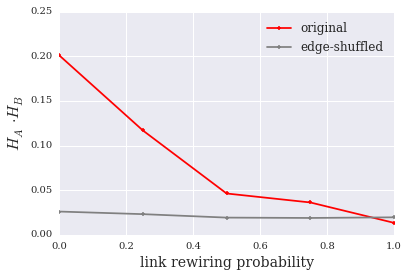

In [47]:
H12 = []
H12_rand = []
num_G_reps=5
for p_rewire in np.linspace(0,1,5):
    print('rewiring probability = ' + str(p_rewire) + '...')
    H12_temp = []
    H12_temp_rand = []
    for r in range(num_G_reps):
        Gsim = nx.connected_watts_strogatz_graph(500,5,p_rewire)

        seed1 = Gsim.nodes()[0:5]
        seed2 = Gsim.nodes()[5:10]
        seed3 = Gsim.nodes()[20:30]


        results_dict = network_prop.calc_3way_colocalization(Gsim,seed1,seed2,seed3,num_reps=20,num_genes=5,
                                                             replace=False,savefile=False,alpha=.5,print_flag=False)
        H12_temp.append(np.mean(results_dict['sfari_epi']))
        H12_temp_rand.append(np.mean(results_dict['sfari_epi_rand']))
    H12.append(np.mean(H12_temp))
    H12_rand.append(np.mean(H12_temp_rand))
    
plt.plot(np.linspace(0,1,5),H12,'r.-',label='original')
plt.plot(np.linspace(0,1,5),H12_rand,'.-',color='gray',label='edge-shuffled')
plt.xlabel('link rewiring probability',fontsize=14)
plt.ylabel('$H_A \cdot H_B$',fontsize=16)
plt.legend(loc='upper right',fontsize=12)

- We see above, as expected, that as the rewiring probability increases (on the x-axis), and the graph becomes more random, the heat dot-product (co-localization) decreases (on the y-axis), until the co-localization on the original graph matches the edge-shuffled graph.  
- We expect this to be the case because once p-rewire becomes very high, the original graph becomes essentially random, so not much is changed by shuffling the edges. 

# Three-way Co-localization

- Finally, we will look at how our co-localization using network propagation method applies to three seed node sets instead of two.
- This could be useful if the user was interested in establishing if one node set provided a link between two other node sets.  For example, one might find that two node sets are individually not co-localized, but each is co-localized with a third node set.  This third node set would essentially provide the missing link between the two, as illustrated below, where node sets A and C are far apart, but B is close to A, and B is close to C.

<img src="screenshots/CL_triangle.png">

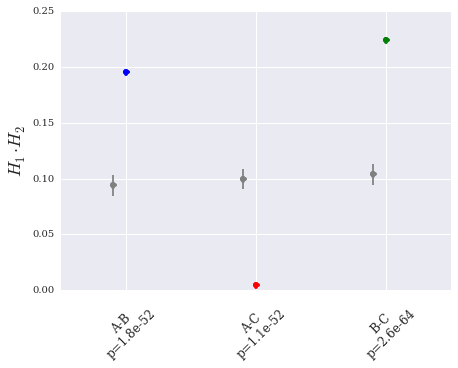

In [40]:

seed1 = Gsim.nodes()[0:5]
seed2 = Gsim.nodes()[5:10]
seed3 = Gsim.nodes()[10:15]


results_dict = network_prop.calc_3way_colocalization(Gsim,seed1,seed2,seed3,num_reps=100,num_genes=5,
                                                     replace=False,savefile=False,alpha=.5,print_flag=False,)

import scipy

num_reps = results_dict['num_reps']

dot_sfari_epi=results_dict['sfari_epi']
dot_sfari_epi_rand=results_dict['sfari_epi_rand']
#U,p = scipy.stats.mannwhitneyu(dot_sfari_epi,dot_sfari_epi_rand)
t,p = scipy.stats.ttest_ind(dot_sfari_epi,dot_sfari_epi_rand)
psig_SE = plotting_results.nsf(p,n=2)

dot_sfari_aem=results_dict['sfari_aem']
dot_aem_sfari_rand=results_dict['aem_sfari_rand']
#U,p = scipy.stats.mannwhitneyu(dot_sfari_aem,dot_aem_sfari_rand)
t,p = scipy.stats.ttest_ind(dot_sfari_aem,dot_aem_sfari_rand)
psig_SA = plotting_results.nsf(p,n=2)

dot_aem_epi=results_dict['aem_epi']
dot_aem_epi_rand=results_dict['aem_epi_rand']
#U,p = scipy.stats.mannwhitneyu(dot_aem_epi,dot_aem_epi_rand)
t,p = scipy.stats.ttest_ind(dot_aem_epi,dot_aem_epi_rand)
psig_AE = plotting_results.nsf(p,n=2)

plt.figure(figsize=(7,5))
plt.errorbar(-.1,np.mean(dot_sfari_epi_rand),2*np.std(dot_sfari_epi_rand)/np.sqrt(num_reps),fmt='o',
             ecolor='gray',markerfacecolor='gray')
plt.errorbar(0,np.mean(dot_sfari_epi),2*np.std(dot_sfari_epi)/np.sqrt(num_reps),fmt='bo')

plt.errorbar(.9,np.mean(dot_aem_sfari_rand),2*np.std(dot_aem_sfari_rand)/np.sqrt(num_reps),fmt='o',
             ecolor='gray',markerfacecolor='gray')
plt.errorbar(1,np.mean(dot_sfari_aem),2*np.std(dot_sfari_aem)/np.sqrt(num_reps),fmt='ro')

plt.errorbar(1.9,np.mean(dot_aem_epi_rand),2*np.std(dot_aem_epi_rand)/np.sqrt(num_reps),fmt='o',
             ecolor='gray',markerfacecolor='gray')
plt.errorbar(2,np.mean(dot_aem_epi),2*np.std(dot_aem_epi)/np.sqrt(num_reps),fmt='go')
plt.xticks([0,1,2],['A-B \np='+str(psig_SE),'A-C \np='+str(psig_SA),'B-C\np='+str(psig_AE)],rotation=45,fontsize=12)
plt.xlim(-.5,2.5)
plt.ylabel('$H_{1} \cdot H_{2}$',fontsize=18)


- In the figure above, we show how three-way co-localization looks in practice.  
- We have selected three node sets, two of which are distant (A and C), and one which is close to both (B).
- We find that indeed $H_A\cdot H_B$ and $H_B\cdot H_C$ (blue dot and green dot) are much higher on the original graph than on the edge shuffled graphs.
- However, we find that $H_A\cdot H_C$ is actually _lower_ than the background noise.  This is telling us that node sets A and C are actually individually localized, but not co-localized at all, because more of the heat remains close to each individual seed set than would happen if each node set was not individually co-localized.